# Reading Data

##  Loading the data


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import nltk
import string
import seaborn
import re
import string as sns  # Tutorial about Python regular expressions: https://pymotw.com/2/re/
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt


from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter 
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter 
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm



C:\Users\admin\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\admin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
rn_gdbt_ar = pd.read_csv('Reviews.csv', nrows= 10000)
rn_gdbt_ar.shape

(10000, 10)

In [5]:
def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = rn_gdbt_ar['Score']
positiveNegative = actualScore.map(partition) 
rn_gdbt_ar['Score'] = positiveNegative
print("Number of data points in our data", rn_gdbt_ar.shape)
rn_gdbt_ar.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning: Deduplication

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=rn_gdbt_ar.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9515, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(rn_gdbt_ar['Id'].size*1.0)*100

95.15

In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9515, 10)


1    8082
0    1433
Name: Score, dtype: int64

#  Featurization

<h2> BOW </h2>

In [11]:
x = rn_gdbt_ar['Text'].values
y= rn_gdbt_ar['Score'].values

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english')
vectorizer.fit(X_train) 
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

(4489,) (4489,)
(2211,) (2211,)
(3300,) (3300,)
After vectorizations
(4489, 123326) (4489,)
(2211, 123326) (2211,)
(3300, 123326) (3300,)


<h2> Represent Of Result </h2>

In [14]:
#https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/XGBOOST_RF_amazon_food_review.ipynb
import seaborn as sns
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
def gdbt_Classifier(X_train,X_cv,y_train,y_cv):
    pred_cv = []
    pred_train = []
    max_depth = [1, 5, 10, 50, 100, 500, 1000]
    n_estimators = [5, 10, 100, 500] 
    for i in max_depth:
        for j in n_estimators:
            clf = GradientBoostingClassifier(max_depth=i, n_estimators=j)
            clf.fit(X_train_bow,y_train)
            probs = clf.predict_proba(X_cv_bow)
            prob = clf.predict_proba(X_train_bow)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(y_cv,probs)
            auc_score_train = roc_auc_score(y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    
    print("-"*30, "Train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(max_depth),len(n_estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, fmt=".3f", xticklabels=n_estimators,yticklabels=max_depth)
    plt.xlabel('N_Estimators')
    plt.ylabel('Max_Depth')
    plt.show()
    print("-"*30, "CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(max_depth),len(n_estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
    plt.xlabel('N_Estimators')
    plt.ylabel('Max_Depth')
    plt.show()

------------------------------ Train data ------------------------------


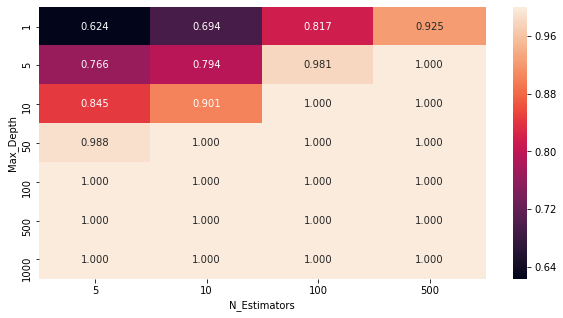

------------------------------ CV data ------------------------------


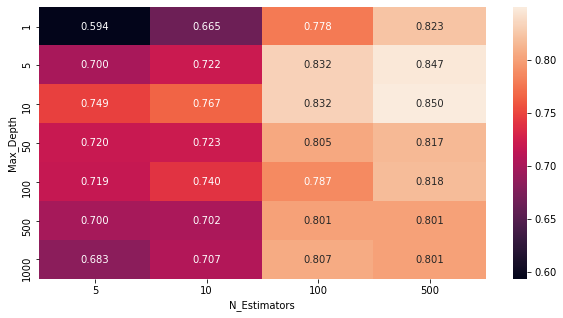

In [15]:
gdbt_Classifier(X_train_bow,X_cv_bow,y_train,y_cv)

# Confusion Matrix

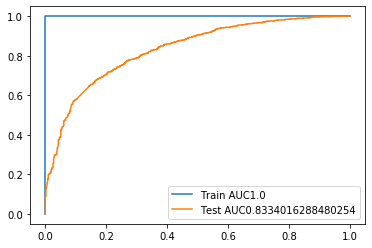

****************************** TRAIN DATA ******************************


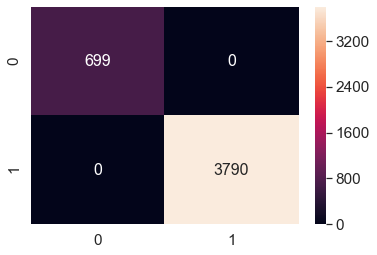

****************************** TEST DATA ******************************


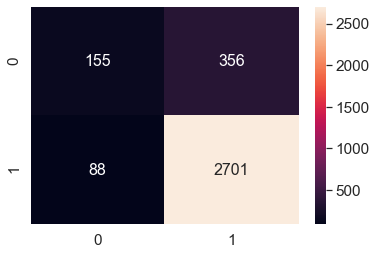

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
rn_gdbt = GradientBoostingClassifier(max_depth=10, n_estimators=500)
rn_gdbt.fit(X_train_bow,y_train)
y_pred = rn_gdbt.predict(X_train_bow)
y_pred_test = rn_gdbt.predict(X_test_bow)
sig_clf = CalibratedClassifierCV(rn_gdbt, method="sigmoid")
sig_clf.fit(X_train_bow, y_train)

y_test_pred_proba = sig_clf.predict_proba(X_test_bow)[:, 1]
y_train_pred_proba = sig_clf.predict_proba(X_train_bow)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("*"*30, "TRAIN DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("*"*30, "TEST DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

# Top Feature Importance

In [39]:
clf = GradientBoostingClassifier(n_estimators=500, max_depth=10)
clf.fit(X_train_bow, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)
pos_class_prob_sorted = clf.feature_importances_[1 :].argsort()
print("Top  Features Importance")
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[10:40]))

Top  Features Importance
['pineapple jerk' 'pineapple isn' 'pineapple helps' 'pineapple good'
 'pineapple flavored' 'pineapple flavor' 'pineapple favorite'
 'pineapple did' 'pineapple delicious' 'pineapple cheese'
 'pineapple changed' 'pineapple cane' 'pineapple br' 'pineapple big'
 'pineapple beer' 'pineapple amazon' 'pineapple save' 'pineapple adds'
 'pineapple shipped' 'pineapple strong' 'pinkish' 'pinkalicious parties'
 'pinkalicious' 'pink red' 'pink pink' 'pink material' 'pink lemonade'
 'pink just' 'pink growing' 'pink grapefruit']


# WordCloud

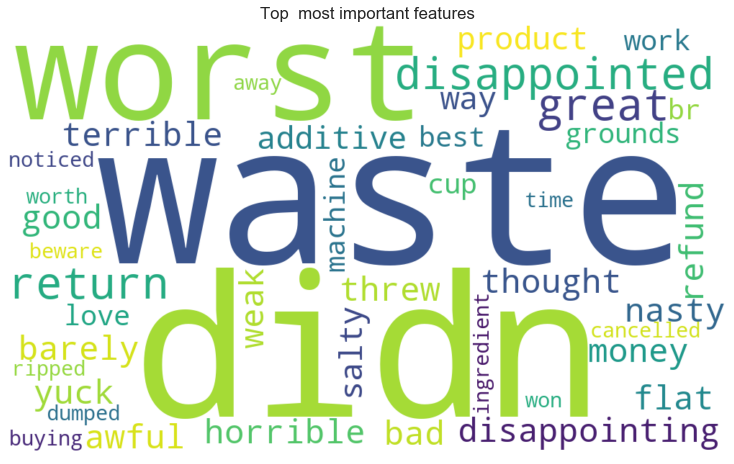

In [40]:
#https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/XGBOOST_RF_amazon_food_review.ipynb
from wordcloud import WordCloud, STOPWORDS
features = vectorizer.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[0:40]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top  most important features")
plt.tight_layout(pad = 0) 
  
plt.show()

# ==========================================================

##  TF-IDF

In [16]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
vectorizer_1 =  TfidfVectorizer(ngram_range=(1,2), stop_words='english')
vectorizer_1.fit(X_train) 

X_train_tfidf = vectorizer.transform(X_train)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(4489, 123326) (4489,)
(2211, 123326) (2211,)
(3300, 123326) (3300,)


# Representation Of Results

In [22]:
#https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/XGBOOST_RF_amazon_food_review.ipynb
import seaborn as sns
def gdbt_Classifier(X_train,X_cv,y_train,y_cv):
    pred_cv = []
    pred_train = []
    max_depth = [1, 5, 10, 50, 100, 500, 1000]
    n_estimators = [5, 10, 100, 500] 
    for i in max_depth:
        for j in n_estimators:
            clf = GradientBoostingClassifier(max_depth=i, n_estimators=j)
            clf.fit(X_train_tfidf,y_train)
            probs = clf.predict_proba(X_cv_tfidf)
            prob = clf.predict_proba(X_train_tfidf)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(y_cv,probs)
            auc_score_train = roc_auc_score(y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    
    print("-"*30, "Train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(max_depth),len(n_estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, fmt=".3f", xticklabels=n_estimators,yticklabels=max_depth)
    plt.xlabel('N_Estimators')
    plt.ylabel('Max_Depth')
    plt.show()
    print("-"*30, "CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(max_depth),len(n_estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
    plt.xlabel('N_Estimators')
    plt.ylabel('Max_Depth')
    plt.show()

------------------------------ Train data ------------------------------


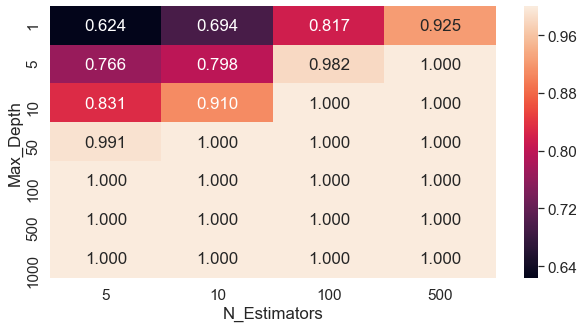

------------------------------ CV data ------------------------------


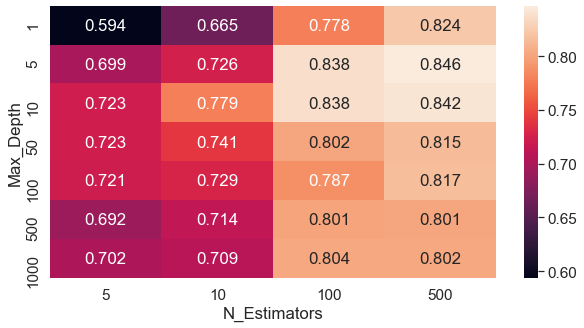

In [23]:
gdbt_Classifier(X_train_tfidf,X_cv_tfidf,y_train,y_cv)

# Confusion Matrix

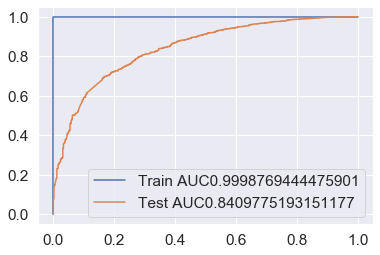

****************************** TRAIN DATA ******************************


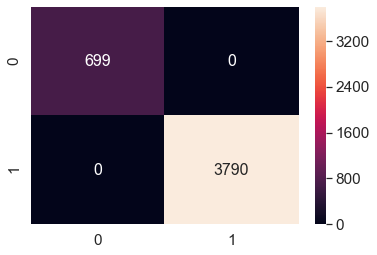

****************************** TEST DATA ******************************


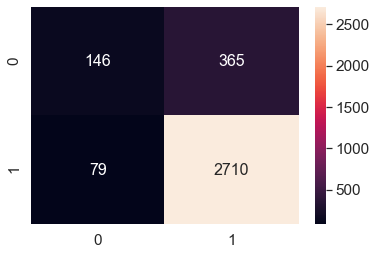

In [17]:
rn_gdbt = GradientBoostingClassifier(max_depth=5, n_estimators=500)
rn_gdbt.fit(X_train_tfidf,y_train)
y_pred = rn_gdbt.predict(X_train_tfidf)
y_pred_test = rn_gdbt.predict(X_test_tfidf)
sig_clf = CalibratedClassifierCV(rn_gdbt, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

y_test_pred_proba = sig_clf.predict_proba(X_test_tfidf)[:, 1]
y_train_pred_proba = sig_clf.predict_proba(X_train_tfidf)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("*"*30, "TRAIN DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("*"*30, "TEST DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

<h2> Top Feature Importance </h2>

In [18]:
clf = GradientBoostingClassifier(n_estimators=500, max_depth=5)
clf.fit(X_train_tfidf, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)
pos_class_prob_sorted = clf.feature_importances_[1 :].argsort()
print("Top  Features Importance)")
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[10:30]))

Top  Features Importance)
['pleased br' 'pleased bought' 'pleased bag' 'pleased baby'
 'pleased babies' 'pleased available' 'pleased arrived' 'pleased amazon'
 'pleased acid' 'pleased able' 'pleased' 'pleasantly suprised'
 'pleasantly pleased' 'pleasantly carbonated' 'pleasantly' 'pleasant wake'
 'pleased dog' 'pleased drink' 'pleased easy' 'pleased favorite']


<h2> WordCloud </h2>

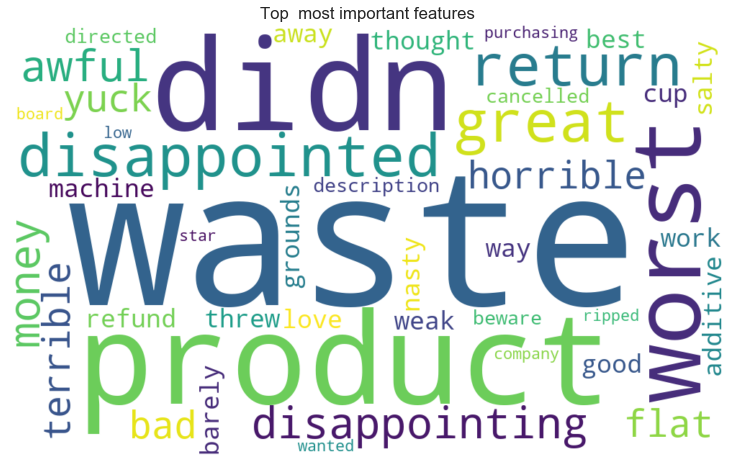

In [19]:
#https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/XGBOOST_RF_amazon_food_review.ipynb
from wordcloud import WordCloud, STOPWORDS

features = vectorizer_1.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[0:40]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top  most important features")
plt.tight_layout(pad = 0) 
  
plt.show()

# =======================================================

##  Word2Vec

In [20]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')


def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|]',r' ',cleaned)
    return cleaned

print(stop)
print('******************************************')
print(sno.stem('tasty'))


{"hadn't", 'as', 'so', 's', 'ourselves', 'do', 'herself', 'about', 'above', 'm', 'was', 'wouldn', 'yourselves', 'when', "should've", 'y', "that'll", 'if', 'there', 'will', 'needn', 're', 'during', 'themselves', 'then', "isn't", 'are', "you're", "it's", 'but', 'while', 'not', 'weren', 'they', 'isn', 'myself', 'other', 'we', 'before', 'my', 'very', 'into', "couldn't", 't', 'each', 'now', 'i', 'himself', 'hers', 'nor', "she's", 'these', 'his', 'having', 'few', "weren't", "aren't", 'than', 'has', 'more', 'your', 'its', 'ma', 'under', 'am', 'over', 'after', 'further', 'or', 'by', "doesn't", 'shan', 'is', 'mightn', 'and', 'ours', 'them', 've', 'only', 'their', 'once', "you'd", 'been', 'same', 'couldn', 'an', 'until', 'did', "shan't", 'should', 'o', 'which', 'just', 'don', 'yours', 'didn', 'hasn', 'here', 'a', 'yourself', 'off', 'this', 'all', 'on', 'be', 'what', 'at', 'with', 'you', 'itself', 'does', "mightn't", "wasn't", 'the', 'mustn', 'll', "don't", 'out', "shouldn't", 'wasn', 'being', 'n

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
i=0
str1=''
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in rn_gdbt_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (rn_gdbt_ar['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (rn_gdbt_ar['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                    else:
                        continue
                else:
                    continue
    str1 = b" ".join(filtered_sentence)
   # print("***********************************************************************888")
    final_string.append(str1)
    i+=1

In [22]:
rn_gdbt_ar['CleanedText']=final_string

In [23]:
import gensim
from gensim.models import word2vec
from gensim.models import keyedvectors
import pickle
#import gensim


i=0
list_of_sent=[]
for sent in rn_gdbt_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence) 

In [24]:
print(rn_gdbt_ar['Text'].values[0])
print("***********************************************************************************")
print(list_of_sent[0])
# conda install gensim 

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
***********************************************************************************
['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


<h2> Word2Vec Featurization in Train Data </h2>

In [25]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [26]:
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5465
sample words  ['I', 'must', 'be', 'a', 'bit', 'of', 'because', 'this', 'soup', 'tastes', 'to', 'me', 'how', 'imagine', 'might', 'taste.', 'like', 'spicy', 'food', 'if', 'it', 'has', 'good', 'flavor.', "don't", 'find', 'the', 'case', 'with', 'soup.', 'Any', 'flavor', 'is', 'off', 'by', 'i', 'love', 'product', '!', 'ive', 'tried', 'several', 'different', 'one', 'best.', 'unlike', 'most', 'people,', 'k', 'cups']


In [28]:
from tqdm import tqdm 
  


sent_vectors = [];
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.51it/s]


10000
50


In [29]:
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50) 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|█████████████████████████████████████████████████████████████████████████████| 4489/4489 [00:19<00:00, 228.07it/s]


(4489, 50)
[-0.06520991  0.08902115 -0.0193135   0.13958489 -0.10475755 -0.17500601
  0.21344207 -0.11290722 -0.03225421 -0.11174584  0.19213772  0.02155299
  0.01891031 -0.03344529  0.07786073  0.00407302 -0.09274305  0.07727382
  0.12012186  0.12381718 -0.0824071  -0.06218948  0.09072475 -0.22276059
 -0.11608762 -0.07649156  0.01461663  0.0013727  -0.05661419 -0.05914096
  0.05041706  0.00424069 -0.03616759 -0.13417167 -0.04645456  0.07137123
  0.0640202  -0.07806485 -0.0337992  -0.04389799 -0.08502648 -0.17083279
  0.07620274  0.01047935 -0.02738169  0.06493942 -0.01158363 -0.02839947
 -0.0463627  -0.08733167]


<h2> Word2Vec Featurization In  Cross-Validation </h2>

In [30]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [31]:
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 2211/2211 [00:11<00:00, 186.07it/s]


(2211, 50)
[-3.34109746e-01  5.90153216e-01  1.30517679e-02  6.04033676e-01
 -5.06497688e-01 -8.78134816e-01  9.52027311e-01 -5.57049588e-01
 -1.72794324e-01 -5.90497214e-01  1.17257074e+00 -5.96688495e-02
  1.78414002e-01  5.05758027e-03  4.30593752e-01 -6.04126302e-02
 -6.22214378e-01  5.07429878e-01  6.21454419e-01  5.38822360e-01
 -5.89917773e-02 -1.87840039e-01  4.12635252e-01 -1.14281757e+00
 -3.54875331e-01 -5.47596631e-01 -1.08453609e-01  2.16796967e-01
 -2.02534772e-01 -1.22805762e-01  1.80309852e-01  8.30629584e-04
 -2.50423578e-01 -6.68305556e-01 -2.72200407e-01  2.37458721e-01
  2.33384396e-01 -5.93357690e-01  9.00807237e-02 -2.64977088e-01
 -4.06165266e-01 -7.36845706e-01  3.69658922e-01  6.80379967e-03
  1.78958857e-03  3.41802275e-01  3.26370431e-02 -1.59132539e-02
 -1.50340593e-01 -3.89560354e-01]


<h2> Word2Vec Featurization In Test Data </h2>

In [32]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [33]:
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 3300/3300 [00:21<00:00, 150.93it/s]


(3300, 50)
[-0.21627045  0.49043455  0.04628338  0.87149179 -0.58237669 -0.78106252
  1.28315726 -0.61324856  0.09482993 -0.41513523  1.06754298  0.28063384
 -0.26219211 -0.22268642  0.57811876  0.01796367 -0.47706988  0.14557515
  0.80126104  0.56812953 -0.45465215 -0.10977516  0.44011934 -1.10893622
 -0.58167672 -0.32728569  0.06367426 -0.21244913 -0.43076562 -0.12740774
  0.23227102  0.10888198 -0.15534696 -0.6545818  -0.40742556  0.25412791
  0.48142271 -0.33919889 -0.53513293 -0.07359787 -0.47241054 -0.89064326
  0.48343611  0.27948094 -0.11994305  0.15153203  0.10319322 -0.11226402
  0.04343915 -0.63120988]


<h2> Representation Of Results </h2>

In [38]:
#https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/XGBOOST_RF_amazon_food_review.ipynb
import seaborn as sns
def gdbt_Classifier(X_train,X_cv,y_train,y_cv):
    pred_cv = []
    pred_train = []
    max_depth = [1, 5, 10, 50, 100, 500, 1000]
    n_estimators = [5, 10, 100, 500] 
    for i in max_depth:
        for j in n_estimators:
            clf = GradientBoostingClassifier(max_depth=i, n_estimators=j)
            clf.fit(sent_vectors_train,y_train)
            probs = clf.predict_proba(sent_vectors_cv)
            prob = clf.predict_proba(sent_vectors_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(y_cv,probs)
            auc_score_train = roc_auc_score(y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    
    print("-"*30, "Train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(max_depth),len(n_estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, fmt=".3f", xticklabels=n_estimators,yticklabels=max_depth)
    plt.xlabel('N_Estimators')
    plt.ylabel('Max_Depth')
    plt.show()
    print("-"*30, "CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(max_depth),len(n_estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
    plt.xlabel('N_Estimators')
    plt.ylabel('Max_Depth')
    plt.show()

------------------------------ Train data ------------------------------


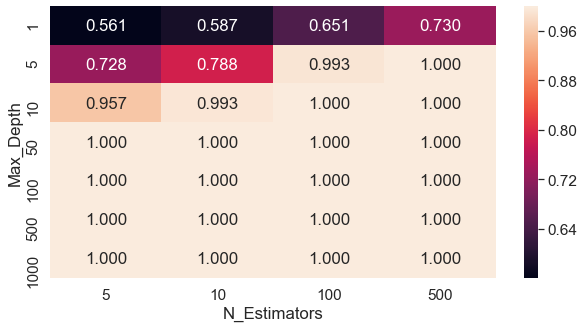

------------------------------ CV data ------------------------------


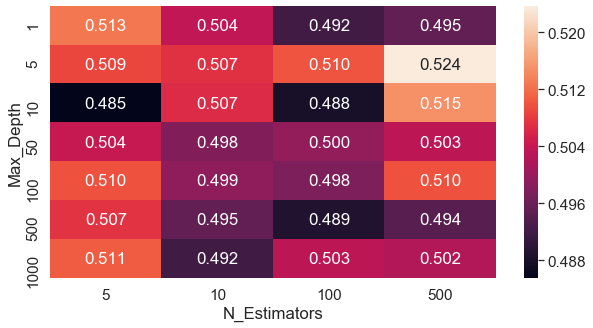

In [39]:
gdbt_Classifier(sent_vectors_train,sent_vectors_cv,y_train,y_cv)

# Confusion Matrix

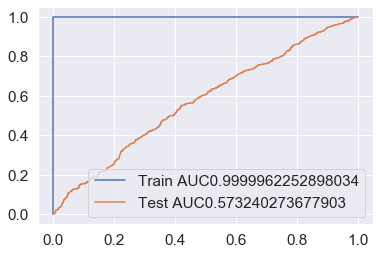

****************************** TRAIN DATA ******************************


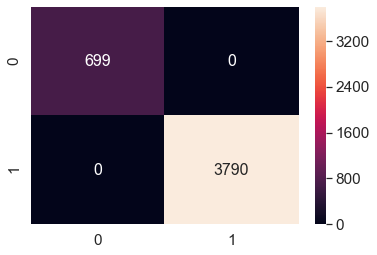

****************************** TEST DATA ******************************


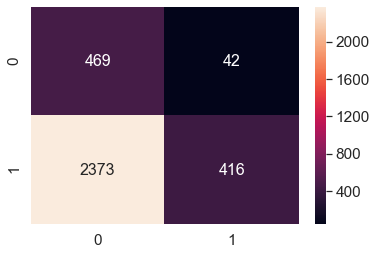

In [34]:
rn_gdbt = GradientBoostingClassifier(max_depth=5, n_estimators=500)
rn_gdbt.fit(sent_vectors_train,y_train)
y_pred = rn_gdbt.predict(sent_vectors_train)
y_pred_test = rn_gdbt.predict(sent_vectors_test)
sig_clf = CalibratedClassifierCV(rn_gdbt, method="sigmoid")
sig_clf.fit(sent_vectors_train, y_train)

y_test_pred_proba = sig_clf.predict_proba(sent_vectors_test)[:, 1]
y_train_pred_proba = sig_clf.predict_proba(sent_vectors_train)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("*"*30, "TRAIN DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("*"*30, "TEST DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

<h2>========================================================================= </h2>

<h2> AvgW2V </h2>

<h2> AvgW2V In Train Data </h2>

In [35]:
from tqdm import tqdm 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(rn_gdbt_ar['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()
tfidf_sent_vectors_train = [];
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

100%|██████████████████████████████████████████████████████████████████████████████| 4489/4489 [05:48<00:00, 12.89it/s]


(4489, 50)
[-0.62514933  0.99227025  0.1393844   0.6763984  -0.31731684 -0.52258739
  1.14100218 -0.55368673 -0.43166993 -0.36633075  0.89090253 -0.02164281
  0.07767954 -0.69831468 -0.05888524  0.24383077 -0.51037001  0.22360352
  0.57214347  0.43759433 -0.82931982 -0.613841    0.71535054 -1.37614884
 -0.46923276 -0.44719328  0.49138557 -0.28178563 -0.37208815 -0.28266614
  0.32026621  0.05233412  0.19389792 -0.87700121  0.03694558  0.07426045
  0.14745345 -0.42362767 -0.11680909 -0.35469582 -0.83826874 -1.3127543
  0.51430267  0.24584336 -0.44188976  0.55009978 -0.01727548 -0.74915745
 -0.03834783 -0.93895846]


<h2> AvgW2V In Cross-Validation </h2>

In [36]:
from tqdm import tqdm 
model = TfidfVectorizer()
tfidf_sent_vectors_cv = [];
row=0;
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

100%|██████████████████████████████████████████████████████████████████████████████| 2211/2211 [02:49<00:00, 24.53it/s]


(2211, 50)
[-2.63509184e-01  5.41742697e-01 -3.00325208e-02  5.88016442e-01
 -4.34836188e-01 -6.22101259e-01  1.05702891e+00 -4.29687184e-01
 -1.27079662e-01 -3.90638956e-01  8.77654367e-01  2.12585192e-02
 -2.31602735e-02 -6.53279948e-02  2.61623931e-01 -2.18432422e-02
 -4.59583974e-01  2.15070172e-01  4.55330182e-01  4.56968025e-01
 -1.84744722e-01 -1.99375240e-01  3.71468910e-01 -7.61443069e-01
 -3.15235960e-01 -4.16173317e-01  1.36406767e-01  5.13785807e-03
 -7.58641731e-02 -2.30229332e-01  1.37113750e-01 -1.74924042e-02
 -9.52201772e-02 -4.33030320e-01 -1.74621841e-01  1.77994151e-01
  3.86997327e-01 -2.85126722e-01 -7.45058759e-02 -2.15336737e-01
 -4.31341802e-01 -5.14558044e-01  2.84835417e-01  1.39855386e-01
 -1.40444257e-01  2.97238529e-01 -1.01970971e-03 -1.33769506e-01
  1.86791363e-01 -4.28088827e-01]


<h2> AvgW2v In Test Data </h2>

In [37]:
from tqdm import tqdm 
model = TfidfVectorizer()
tfidf_sent_vectors_test = [];
row=0;
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])   

100%|██████████████████████████████████████████████████████████████████████████████| 3300/3300 [04:25<00:00,  7.94it/s]


(3300, 50)
[-0.1407438   0.6151963   0.01860024  0.84278039 -0.67006798 -0.67784901
  1.44743332 -0.56765935  0.06399574 -0.29546147  0.89331946  0.3701221
 -0.46848128 -0.22954401  0.46393569  0.08682782 -0.49987655 -0.16431037
  0.68042902  0.43401931 -0.52756066 -0.15270727  0.40133386 -0.73733643
 -0.48533991 -0.27174723  0.22565426 -0.30250936 -0.23750921 -0.24531952
  0.27363901  0.1215177  -0.07412693 -0.47215285 -0.34578576  0.11272617
  0.51054379 -0.1398264  -0.55478853 -0.04535441 -0.61167854 -0.55123361
  0.31366797  0.37931344 -0.24317332  0.1366133   0.03798176 -0.24299115
  0.39856191 -0.72668544]


<h2> Representation Of Results </h2>

In [41]:
#https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/XGBOOST_RF_amazon_food_review.ipynb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
def gdbt_Classifier(X_train,X_cv,y_train,y_cv):
    pred_cv = []
    pred_train = []
    max_depth = [1, 5, 10, 50, 100, 500, 1000]
    n_estimators = [5, 10, 100, 500] 
    for i in max_depth:
        for j in n_estimators:
            clf = GradientBoostingClassifier(max_depth=i, n_estimators=j)
            clf.fit(tfidf_sent_vectors_train,y_train)
            probs = clf.predict_proba(tfidf_sent_vectors_cv)
            prob = clf.predict_proba(tfidf_sent_vectors_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(y_cv,probs)
            auc_score_train = roc_auc_score(y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    
    print("-"*30, "Train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(max_depth),len(n_estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, fmt=".3f", xticklabels=n_estimators,yticklabels=max_depth)
    plt.xlabel('N_Estimators')
    plt.ylabel('Max_Depth')
    plt.show()
    print("-"*30, "CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(max_depth),len(n_estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
    plt.xlabel('N_Estimators')
    plt.ylabel('Max_Depth')
    plt.show()

------------------------------ Train data ------------------------------


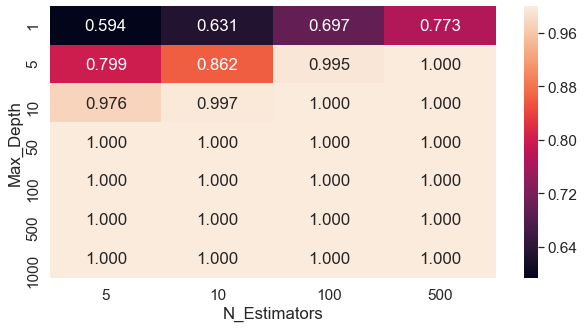

------------------------------ CV data ------------------------------


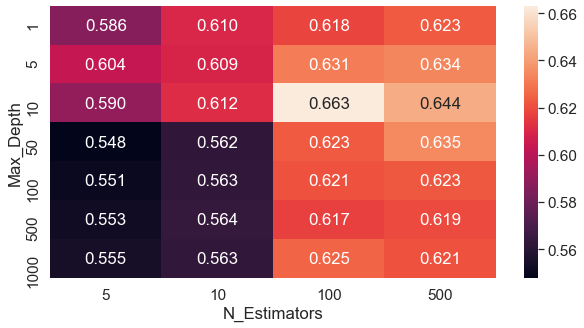

In [42]:
gdbt_Classifier(tfidf_sent_vectors_train, tfidf_sent_vectors_cv,y_train,y_cv)

# Confusion Matrix

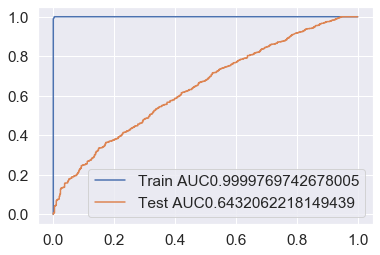

****************************** TRAIN DATA ******************************


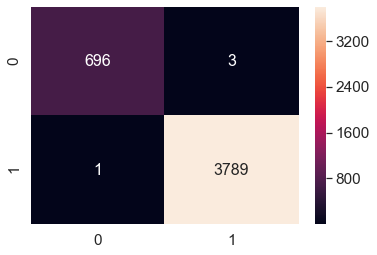

****************************** TEST DATA ******************************


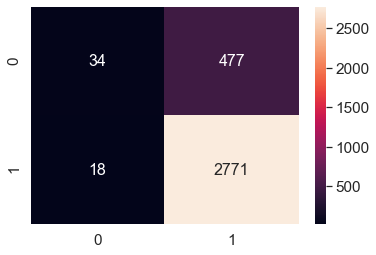

In [38]:
rn_gdbt = GradientBoostingClassifier(max_depth=10, n_estimators=100)
rn_gdbt.fit(tfidf_sent_vectors_train,y_train)
y_pred = rn_gdbt.predict(tfidf_sent_vectors_train)
y_pred_test = rn_gdbt.predict(tfidf_sent_vectors_test)
sig_clf = CalibratedClassifierCV(rn_gdbt, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors_train, y_train)

y_test_pred_proba = sig_clf.predict_proba(tfidf_sent_vectors_test)[:, 1]
y_train_pred_proba = sig_clf.predict_proba(tfidf_sent_vectors_train)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("*"*30, "TRAIN DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("*"*30, "TEST DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

<h2>========================================================================</h2>

<h2> Conclusion Table </h2>

In [44]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Set", "Vectorizer", "Models", "Hyper Parameter", "Train_AUC", "Test_AUC"]

x.add_row(["Set:-1", "BOW", "Random_Forest", 850, 1.0, 0.83])
x.add_row(["Set:-2", "TFIDF", "Random_Forest", 846, 0.99, 0.84])
x.add_row(["Set:-3", "Word2Vec", "Random_Forest", 609, 0.99, 0.57])
x.add_row(["Set:-4", "AvgWord2Vec", "Random_Forest", 597, 0.98, 0.46])
x.add_row(["Set:-5", "BOW", "GradientBoosting", 891, 1.0, 0.83])
x.add_row(["Set:-6", "TFIDF", "GradientBoosting", 895, 0.99, 0.83])
x.add_row(["Set:-7", "Word2Vec", "GradientBoosting", 687, 0.99, 0.47])
x.add_row(["Set:-8", "AvgWord2Vec", "GradientBoosting", 688, 0.99, 0.64])

print(x)

+--------+-------------+------------------+-----------------+-----------+----------+
|  Set   |  Vectorizer |      Models      | Hyper Parameter | Train_AUC | Test_AUC |
+--------+-------------+------------------+-----------------+-----------+----------+
| Set:-1 |     BOW     |  Random_Forest   |       850       |    1.0    |   0.83   |
| Set:-2 |    TFIDF    |  Random_Forest   |       846       |    0.99   |   0.84   |
| Set:-3 |   Word2Vec  |  Random_Forest   |       609       |    0.99   |   0.57   |
| Set:-4 | AvgWord2Vec |  Random_Forest   |       597       |    0.98   |   0.46   |
| Set:-5 |     BOW     | GradientBoosting |       891       |    1.0    |   0.83   |
| Set:-6 |    TFIDF    | GradientBoosting |       895       |    0.99   |   0.83   |
| Set:-7 |   Word2Vec  | GradientBoosting |       687       |    0.99   |   0.47   |
| Set:-8 | AvgWord2Vec | GradientBoosting |       688       |    0.99   |   0.64   |
+--------+-------------+------------------+-----------------+----

# Conclusion:-

1. First i loaded an amazon fine food reviews dataset and took 10k datapoints for featurization
2. Then Did featurization BOW , TF_IDF, W2Vec , and AvgW2Vec featurization and applied  with GradientBoosting classification.
3. Then find top feature Importance in amazon fine food reviews which featrures is importsnce in that dataset and print top feature importance wordcloud.
4. Then did feature Engineering using ungran and bi-gram in amazon fine food reviews
5. Then  find Hyper parameter best 'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'n_estimators': [5, 10, 100, 500] range using gridsearchcrossvalidation .
6. Then plot hyper parameter plot for train data, cross-validation data  .
7. Then find Confusion-Matrix using train data and test data where predicated and actual values calculated with best max_depth and n_estimators in it.

<h2>============================================================================= </h2>